In [1]:
#se intala la libreria para consultar la api de Google Trends
!pip install pytrends

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install pytrends --upgrade

In [ ]:
#faltantes:
#normalizar entre países

In [2]:
from datetime import date

#se sefiene el intervalo de busqueda desde el 2004 hasta el momentio en que se ejecute este código
today = date.today()
Intervalo = ("2010-01-01 "+ str(today))

In [3]:
#importa los paquetes
from pytrends.request import TrendReq
import pandas as pd
from tqdm import tqdm
import datetime as dt
import time
import statsmodels.api as sm
import numpy as np

In [8]:
pytrends = TrendReq(hl='es', tz=360)
suggs = pytrends.suggestions("manifestación")
print(suggs)

[{'mid': '/g/120ry1nd', 'title': 'Manifestación', 'type': 'Tema'}, {'mid': '/g/121crs2g', 'title': 'manifestación', 'type': 'Tema'}, {'mid': '/g/11_ybw1h8', 'title': 'La Iniquidad', 'type': 'Libro de Ana Mendez'}, {'mid': '/g/11mp_klg6l', 'title': '📝DIARIO para Manifestar Deseos con el Método 369: ⭐️⭐️⭐️⭐️⭐️Método Tesla 369 (45 días) GARANTIZADO', 'type': 'Libro de Nikola Tesla'}, {'mid': '/g/11f1rp3vlf', 'title': 'La ley de la atracción', 'type': 'Libro de William Walker Atkinson'}]


In [9]:
#Norma para el query "Manifestación" como tema
Normalizacion = [5.4,0.54,1,3.22,4,8.3,5.3,3.9,1.588235294,1.384615385]


#la normalización es para equiparar las busquedas entre países, el número sale de:
#dividir el max(chile) que es el con el que se calibró el nivel de riesgo / MAx (de cada país)
#este paso se hizo manual a partir del ejercicio inicial

In [10]:
#los países en que se realiza el Query (se ponen el mismo número y mismo orden que los coeficientes de normalizacion)
Paises = ['AR','BR','CL','MX','DO','SV','PA','UY','CO','PE'] # todos los países
#Paises = ['HT','DO'] # solo Haití y Dominicana

#buscar por el tema:
"""pytrends = TrendReq(hl='es', tz=360)
suggs = pytrends.suggestions("manifestación")
print(suggs)"""
#Query por a realizar
Query = ["/g/120ry1nd"]

frames = list()

#pytrends = TrendReq(hl='en-US', tz=360)
pytrends = TrendReq(hl='en-US', tz=360,   retries=2, backoff_factor=0.1, requests_args={'verify':False})


j = 0

#Se itera entre los países
for i in Paises:
    
    #se hace el query
    pytrends.build_payload(Query, timeframe= Intervalo, geo= str(i)) #se construye el query
    data = pytrends.interest_over_time() # se extrae la linea de tiempo (interest_over_time) del query

    ####data = data.rename(columns={"/g/120ry1nd": 'protestas + manifestaciones'})
    data = data.reset_index()
    #Se normaliza
    data[str(Query[0])] = data[str(Query[0])].div(Normalizacion[int(j)])

    # se apilan los resultados en una lista
    frames.append(data)  
    j = j+1
    
    time.sleep(30)
    
#se concatena las lista de resultados en un solo resultado    
result = pd.concat(frames, keys= Paises)
result = result.reset_index()
result.rename(columns={'level_0': 'Pais'}, inplace=True)

/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:842: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:842: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:842: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:842: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certifi

In [11]:
#Se hace el procesamiento y el filtro HP
lamnda = 60 #venta de filtro hp

resultados = list()
for i in Paises:
    data = result[result['Pais'] == str(i)] #el data no es el 
    Dataref = data.copy()
    #se reemplaza los 0 para no generar error con el log
    Dataref['log'] = data[str(Query[0])].replace(0, 0.01)
    #Se saca el logaritmo natural
    Dataref['log'] = np.log(Dataref['log'])
    #Se aplica el filtro
    Dataref['cycle'], Dataref['trend'] = sm.tsa.filters.hpfilter(Dataref['log'], lamnda)
    
    # se asigna el nivel de riesgo social
    
    #se puede comentar desde acá 
    
    """estado = []
    for i in Dataref['trend']:
        if i > 1.4:
            if i > 2:
                nivelriesgo = "Muy Alto"
            else:
                nivelriesgo = "Alto"
        else:
            nivelriesgo = "Bajo" 
        estado.append(nivelriesgo)
    Dataref['Estado del riesgo'] = estado"""
    #se puede comentar hasta acá 
    
    resultados.append(Dataref) 
    
    
Final = pd.concat(resultados, keys= Paises)


try:
    Final = Final.reset_index()
except:
    pass
Final.to_csv('TermometroRsocial.csv')

In [14]:
Final_trend = Final[['date','Pais', 'trend']]
Final_trend

date Pais     trend
AR 0    2010-01-01   AR  0.424288
   1    2010-02-01   AR  0.592473
   2    2010-03-01   AR  0.748585
   3    2010-04-01   AR  0.877226
   4    2010-05-01   AR  0.967552
...            ...  ...       ...
PE 1575 2022-10-01   PE  2.942613
   1576 2022-11-01   PE  2.998864
   1577 2022-12-01   PE  3.068067
   1578 2023-01-01   PE  3.141699
   1579 2023-02-01   PE  3.211912

[1580 rows x 3 columns]

<AxesSubplot:xlabel='date', ylabel='trend'>

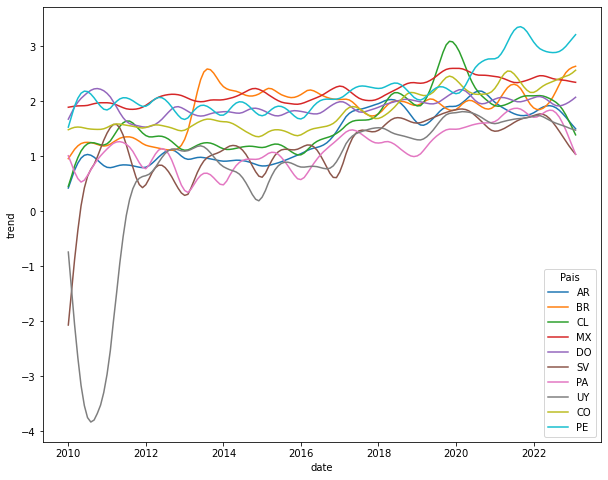

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.lineplot(data = Final_trend, x = 'date', y= 'trend', hue='Pais')

In [ ]:
from google.colab import files
files.download('TermometroRsocial.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
result[result['Pais'] == 'CO']

,Pais,level_1,date,/g/120ry1nd,isPartial
0,DO,0,2010-01-01,0.000000,False
1,DO,1,2010-02-01,6.481481,False
2,DO,2,2010-03-01,7.407407,False
3,DO,3,2010-04-01,5.000000,False
4,DO,4,2010-05-01,7.037037,False
...,...,...,...,...,...
149,DO,149,2022-06-01,6.481481,False
150,DO,150,2022-07-01,3.888889,False
151,DO,151,2022-08-01,2.592593,False
152,DO,152,2022-09-01,3.888889,False


In [ ]:
result.to_csv('TermometroGoogleTrends.csv')


In [ ]:
#sugerencia de que termino equivale a que tema ya clasificado por Google

pytrends = TrendReq(hl='es', tz=360)
suggs = pytrends.suggestions("estanflación")
print(suggs)

[{'mid': '/m/06njd', 'title': 'Estanflación', 'type': 'Tema'}]


In [ ]:
# Descomentar esto si solo quiero importar el archivo guardado para no volver a correr google trends
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#Final = pd.read_csv('TermometroRsocial.csv')

In [ ]:
df_do = Final[Final['Pais'] == 'DO']
#df_do = df_do[df_do['isPartial'] == False]
df_do_5y = df_do[df_do['date'] >= '2018-12-31']
df_do_5y.head()

,Unnamed: 0,Unnamed: 1,Pais,level_1,date,/g/120ry1nd,isPartial,log,cycle,trend
108,DO,108,DO,108,2019-01-01,4.629630,False,1.532477,-0.152009,1.684485
109,DO,109,DO,109,2019-02-01,6.296296,False,1.839962,0.174227,1.665735
110,DO,110,DO,110,2019-03-01,6.666667,False,1.897120,0.252709,1.644411
111,DO,111,DO,111,2019-04-01,5.370370,False,1.680897,0.059053,1.621844
112,DO,112,DO,112,2019-05-01,5.000000,False,1.609438,0.005862,1.603576


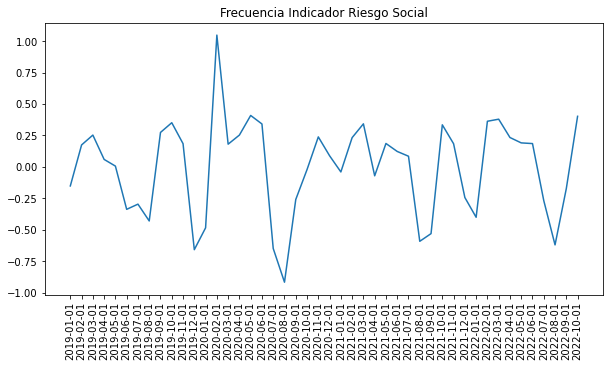

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df_do_5y['date'], df_do_5y['cycle'])
plt.xticks(rotation = 90)
plt.title('Frecuencia Indicador Riesgo Social')
plt.show()

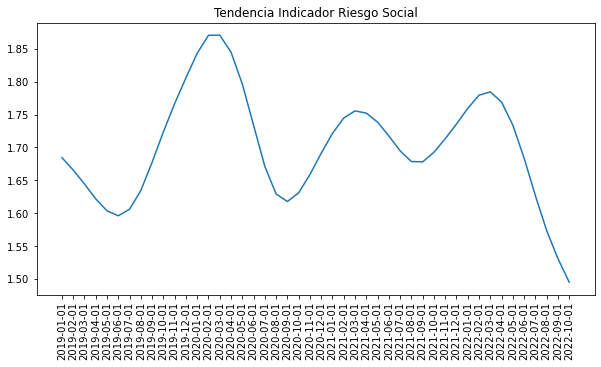

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_do_5y['date'], df_do_5y['trend'])
plt.xticks(rotation = 90)
plt.title('Tendencia Indicador Riesgo Social')
plt.show()